<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/multiframeEstimation/blob/main/feature_integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Mon Apr 26 21:09:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# ! wget http://lightfield.stanford.edu/data/lego_lf/originals.zip
# ! unzip -q originals.zip

In [ ]:
! unzip -q /content/drive/MyDrive/blender_512.zip -d scenes

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img, norm = True):
    npimg = img.numpy()
    if norm:
        npimg = (np.clip(npimg * 1.4 + 1.3, 0, 8)/8)
    npimg = npimg**0.5
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def print_stat(narray, narray_name = "Array"):
    print(narray_name, "shape: ", narray.shape, "dtype:", narray.dtype)
    arr = narray.flatten()
    print(narray_name , "stat: max: {}, min: {}, mean: {}, std: {}".format(arr.max(), arr.min(), arr.mean(), arr.std()))

def load_exr(path):
        img = cv2.imread(path,cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
random.seed(38)
np.random.seed(38)
torch.manual_seed(38)

In [ ]:
class camMosaicModelTensor:
    def __init__(self):
        ''' params that are from experiments on EVETAR camera '''
        self.sigma_r = 5.3e-4
        self.sigma_s = 8.9e-5
        self.bit_depth = 10
        self.black_level = 50
        ''' params that are NOT from experiments on EVETAR camera '''
        self.amplitude = 2 * 4 * 16

    def noise_model(self, img_gt):
        '''
        follow the noise model of signal-dependent normal distribution
        '''
        sigma_noise = np.sqrt(self.sigma_r**2 + self.sigma_s*img_gt)
        # print(sigma_noise)
        noise = torch.randn_like(img_gt) * sigma_noise
        # print(noise.size(), noise.max(), noise.min())
        img_noisy = img_gt + noise
        return img_noisy

    def rgb2bayer(self, img):
        '''
        filter a full RGB frame to be a raw frame.
        '''
        n_frame, c, h, w = img.shape
        bayer_img = torch.zeros(n_frame, 1, h, w)
        bayer_img[..., 0, ::2, ::2] = img[..., 0, ::2, ::2]
        bayer_img[..., 0, 1::2, 1::2] = img[..., 2, 1::2, 1::2]
        bayer_img[..., 0, ::2, 1::2] = img[..., 1, ::2, 1::2]
        bayer_img[..., 0, 1::2, ::2] = img[..., 1, 1::2, ::2]
        return bayer_img

    def rgb2bayer_3chan(self, img):
        n_frame, c, h, w = img.shape
        bayer_img = torch.zeros(n_frame, 3, h, w)
        bayer_img[..., 0, ::2, ::2] = img[..., 0, ::2, ::2]
        bayer_img[..., 2, 1::2, 1::2] = img[..., 2, 1::2, 1::2]
        bayer_img[..., 1, ::2, 1::2] = img[..., 1, ::2, 1::2]
        bayer_img[..., 1, 1::2, ::2] = img[..., 1, 1::2, ::2]
        return bayer_img

    def rgb2bayer_4chan(self, img):
        n_frame, c, h, w = img.shape
        bayer_img = torch.zeros(n_frame, 4, h//2, w//2)
        bayer_img[..., 0, :, :] = img[..., 0, ::2, ::2]
        bayer_img[..., 1, :, :] = img[..., 1, ::2, 1::2]
        bayer_img[..., 2, :, :] = img[..., 2, 1::2, ::2]
        bayer_img[..., 3, :, :] = img[..., 1, 1::2, 1::2]
        return bayer_img

    def spatial_sampling(self, img, pix = 1):
        n_frame, c, h, w = img.shape
        return F.avg_pool2d(img, pix) * pix**2

    def develop(self, img_gt):
        '''
        develop raw frame from ground truth via the noise model, quantization, CFA.
        '''
        img = self.spatial_sampling(img_gt)
        img_noisy = self.noise_model(img)
        sensor_noisy = torch.clamp(torch.round(img_noisy * self.amplitude) + self.black_level,
                               0, 2**self.bit_depth)
        sensor_noisy_float = (sensor_noisy - self.black_level)/(2**self.bit_depth - self.black_level)
        bayer_noisy = self.rgb2bayer_3chan(sensor_noisy)
        bayer_noisy_float = self.rgb2bayer_3chan(sensor_noisy_float)
        return sensor_noisy_float, bayer_noisy_float

In [ ]:
import os
import cv2

class SynDataset(torch.utils.data.Dataset):
    def __init__(self, root, train = True, transform = None):
        self.root = root
        self.train = train
        self.transform = transform
        self.cam = camMosaicModelTensor()

    def __len__(self):
        if self.train:
            return 16 * 100
        else:
            return 4 * 100
    
    def __getitem__(self, index):
        i = index if self.train else index+16*100
        Xs = []
        for j in range(9):
            # X = load_exr(os.path.join(self.root, "scene{:04d}".format(i), 
            #                         "Image", "Image{:04d}.exr".format(j + 1)))
            X = load_exr(os.path.join(self.root, "scene{:04d}".format(i//100), 
                                    "Image", "Image{:04d}.exr".format(i%100+1)))
            Xs.append(X)
        Xs = np.stack(Xs)
        Xs = self.randomCrop(Xs)
        Xs = torch.from_numpy(Xs.transpose(0, 3, 1, 2)).float()
        _, X = self.cam.develop(Xs)

        return X, (Xs[4] - 1.3)/1.4

    def randomCrop(self, img, size = 256):
        n_frame, H, W, C = img.shape
        # x = np.random.randint(0, H - size + 1)
        # y = np.random.randint(0, W - size + 1)
        x = np.random.randint(4, H - size - 3)
        y = np.random.randint(4, W - size - 3)
        crop_img = np.empty((n_frame, size, size, C))
        k = 0
        offset = [-3, 0, 3]
        for i in range(3):
            for j in range(3):
                crop_img[k] = img[k, x+offset[i]:x+offset[i]+size, y+offset[j]:y+offset[j]+size]
                k += 1
        return crop_img

trainset = SynDataset(root='/content/scenes', train=True, transform=None) ## set root to '.' doesnt work
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testset = SynDataset(root='/content/scenes', train=False, transform=None)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


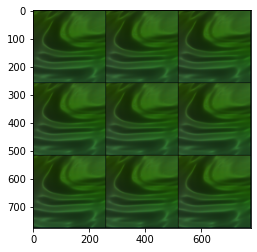

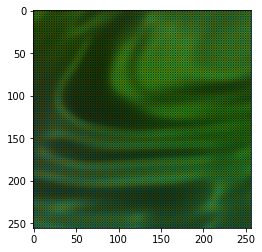

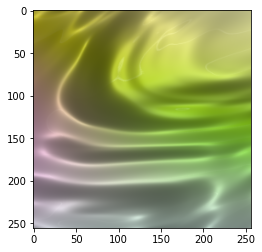

Array shape:  torch.Size([9, 3, 256, 256]) dtype: torch.float32
Array stat: max: 0.9229979515075684, min: 0.0, mean: 0.11188086867332458, std: 0.19687002897262573


In [ ]:
dataiter = iter(trainloader)
images, targets = dataiter.next()
imshow(torchvision.utils.make_grid(images[0], nrow = 3), False)
imshow(torchvision.utils.make_grid(images[0].mean(dim=0)), False)
imshow(torchvision.utils.make_grid(targets[:1]))
print_stat(images[0])

In [ ]:
def conv3x3(in_planes, out_planes, stride=1, groups=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True, groups=groups)

def deconv4x4(in_planes, out_planes, stride=2):
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size=4, stride=stride, padding=1, bias=True)
    
class colorEncoder(nn.Module):
    def __init__(self, in_planes, feature_planes):
        super(colorEncoder, self).__init__()
        '''encoder'''
        self.encoder = nn.Sequential(
            conv3x3(in_planes, 64, 2),
            nn.ReLU(inplace = True),
            conv3x3(64, 64, 2),
            nn.ReLU(inplace = True),
            conv3x3(64, feature_planes, 2),
            nn.ReLU(inplace = True),
        )
    def forward(self, x):
        features = self.encoder(x)
        return features

class colorDecoder(nn.Module):
    def __init__(self, in_planes, feature_planes):
        super(colorDecoder, self).__init__()
        '''decoder'''
        self.decoder = nn.Sequential(
            deconv4x4(feature_planes, 256),
            nn.ReLU(inplace = True),
            deconv4x4(256, 64),
            nn.ReLU(inplace = True),
            deconv4x4(64, in_planes)
        )
    def forward(self, x):
        x = self.decoder(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
in_planes = 3
feature_planes = 128
encoder = colorEncoder(in_planes, feature_planes).to(device)
decoder = colorDecoder(in_planes, feature_planes * 9).to(device)
state_dict = torch.load('color_ae_on_512_synthetic.pt')
encoder_dict = {k: v for k, v in state_dict.items() if "encoder" in k}
encoder.load_state_dict(encoder_dict)
encoder.eval()
for param in encoder.parameters():
    param.requires_grad = False

In [ ]:
print(encoder)

colorEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
)


1st features of 16 low res frames vs 1st feature of high res frame

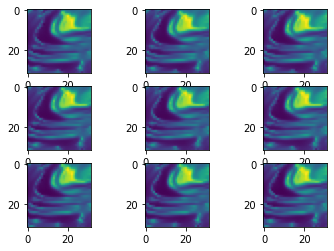

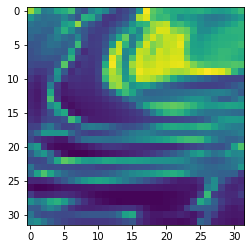

In [ ]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

encoder.encoder[-1].register_forward_hook(get_activation('in_feature'))
output = encoder(images[0].to(device))
act_lr = activation['in_feature'].detach().cpu()

## first features of 9 frames
fig, axarr = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        axarr[i][j].imshow(act_lr[i*3+j, 0])
plt.show()

encoder.encoder[-1].register_forward_hook(get_activation('out_feature'))
output = encoder(targets[:1].to(device))
act_hr = activation['out_feature'].detach().cpu()

plt.imshow(act_hr[0, 0])
plt.show()

In [ ]:
act_lr.size()

torch.Size([9, 128, 32, 32])

In [ ]:
shuffled = F.pixel_shuffle(act_lr.permute(1, 0, 2, 3), 3).permute(1, 0, 2, 3)
shuffled.size()

torch.Size([1, 128, 96, 96])

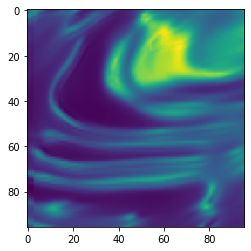

In [ ]:
plt.imshow(shuffled[0, 0])
plt.show()

feature estimation

In [ ]:
class colorDecoder(nn.Module):
    def __init__(self, in_planes, feature_planes):
        super(colorDecoder, self).__init__()
        '''decoder'''
        self.decoder = nn.Sequential(
            deconv4x4(feature_planes, 128),
            nn.ReLU(inplace = True),
            deconv4x4(128, 64),
            nn.ReLU(inplace = True),
            deconv4x4(64, in_planes)
        )
    def forward(self, x):
        x = self.decoder(x)
        return x

decoder = colorDecoder(in_planes, feature_planes * 9).to(device)

def print_model_params(model):
    print("#total params:", sum(p.numel() for p in model.parameters()), end='')
    print(" | #trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))
model = decoder
print_model_params(model)

#total params: 2493635 | #trainable params: 2493635


In [ ]:
trainset = SynDataset(root='/content/scenes', train=True, transform=None) ## set root to '.' doesnt work
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)
testset = SynDataset(root='/content/scenes', train=False, transform=None)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

In [ ]:
## train network
import torch.optim as optim
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train(model, optimizer, n_epoch, trainloader, loss_fn):
    for epoch in range(n_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            with torch.no_grad():
                assert inputs.size(0) == 1
                inputs = inputs.squeeze() ## [9, 3, 256, 256]
                feature = encoder(inputs) ## [9, 128, 32, 32]
                n_f, c, h, w = feature.size()
                feature = feature.view(1, n_f * c, h, w)
                # feature = F.pixel_shuffle(feature.permute(1, 0, 2, 3), 4).permute(1, 0, 2, 3) 
                #                                                         ## [1, 128, 32, 32]
                # output_feature = encoder(targets) ## [1, 128, 32, 32]

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(feature)

            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print('epoch %d -- loss: %.3f' %
                    (epoch+1, running_loss/(i+1)))
        running_loss = 0.0

    print('Finished Training')

train(model, optimizer, 10, trainloader, loss_fn)

epoch 1 -- loss: 0.182
epoch 2 -- loss: 0.033
epoch 3 -- loss: 0.024
epoch 4 -- loss: 0.018
epoch 5 -- loss: 0.016
epoch 6 -- loss: 0.015
epoch 7 -- loss: 0.013
epoch 8 -- loss: 0.012
epoch 9 -- loss: 0.011
epoch 10 -- loss: 0.011
Finished Training


In [ ]:
torch.save(model.state_dict(), "feature_decoder.pt")

In [ ]:
def test(model, testloader, loss_fn):
    with torch.no_grad():
        running_loss = 0.0

        for i, data in enumerate(testloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            assert inputs.size(0) == 1
            inputs = inputs.squeeze() ## [16, 3, 64, 64]
            feature = encoder(inputs) ## [16, 128, 8, 8]
            n_f, c, h, w = feature.size()
            feature = feature.view(1, n_f * c, h, w)

            outputs = model(feature)
            loss = loss_fn(outputs, targets)

            # print statistics
            running_loss += loss.item()
        print('test loss: %.3f' %
                    (running_loss/(i+1)))
        running_loss = 0.0

    print('Finished testing')

model.eval()
test(model, testloader, loss_fn)

test loss: 0.011
Finished testing


In [ ]:
dataiter = iter(testloader)
inputs, targets = dataiter.next()
inputs = inputs.to(device)
targets = targets.to(device)

assert inputs.size(0) == 1

model.eval()
with torch.no_grad():
    inputs = inputs.squeeze() ## [16, 3, 64, 64]
    feature = encoder(inputs) ## [16, 128, 8, 8]
    n_f, c, h, w = feature.size()
    feature = feature.view(1, n_f * c, h, w)

    outputs = model(feature).detach()

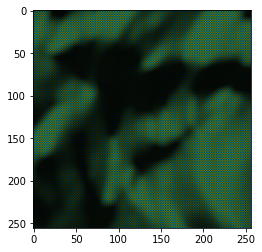

In [ ]:
imshow(torchvision.utils.make_grid(inputs.cpu().mean(dim = 0)), False)

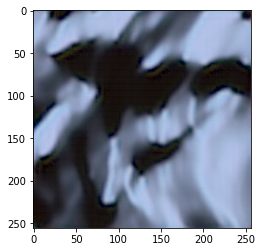

In [ ]:
imshow(torchvision.utils.make_grid(outputs.cpu()))

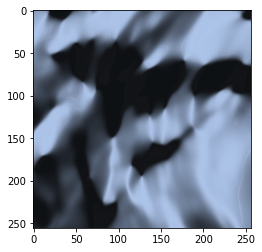

In [ ]:
imshow(torchvision.utils.make_grid(targets.cpu()))

In [ ]:
torch.square(outputs - targets).mean()

tensor(0.0084, device='cuda:0')

In [ ]:
from scipy import interpolate as interp
def demosaic(rawImage):  
    red=rawImage[0, ::2,::2]
    redU=interp.RectBivariateSpline(np.arange(0,128),np.arange(0,128),red)
    red=redU(np.arange(0,128,.5),np.arange(0,128,.5))
    blue=rawImage[2, 1::2,1::2]
    blueU=interp.RectBivariateSpline(np.arange(0,128),np.arange(0,128),blue)
    blue=blueU(np.arange(0,128,.5),np.arange(0,128,.5))
    green=rawImage[1];
    for er in range(0,255,2):
        for odr in range(0,256,2):
            green[er,odr]=np.mean([green[er-1,odr], green[er,odr-1],green[er+1,odr], green[er,odr+1]])
    for er in range(1,254,2):
        for odr in range(1,254,2):
            green[er,odr]=np.mean([green[er-1,odr], green[er,odr-1],green[er+1,odr], green[er,odr+1]])
    greenU=interp.RectBivariateSpline(np.arange(0,256),np.arange(0,256),green[0:256,0:256])
    green=greenU(np.arange(0,256,1),np.arange(0,256,1))
    imageOut=np.dstack((red,green,blue))
    return imageOut

In [ ]:
img = inputs[0].cpu().numpy()
print_stat(img)

Array shape:  (3, 256, 256) dtype: float32
Array stat: max: 0.8891170620918274, min: 0.0, mean: 0.08884111791849136, std: 0.19245266914367676


In [ ]:
rgb = demosaic(img) * (1024 - 50) / 128
rgb = (rgb - 1.3)/1.4

In [ ]:
print_stat(rgb)

Array shape:  (256, 256, 3) dtype: float64
Array stat: max: 35.84441345201881, min: -1.856193722260431, mean: 10.254008577303752, std: 10.743907954740724


In [ ]:
print_stat(targets)

Array shape:  torch.Size([1, 3, 256, 256]) dtype: torch.float32
Array stat: max: 3.87890625, min: -0.9091164469718933, mean: 0.5398308038711548, std: 1.409441590309143


In [ ]:
np.square(rgb - targets[0].cpu().numpy().transpose(1, 2, 0)).mean()

182.9741427588452